# HOT Region Visualization

In [1]:
# File names and parameters
input_hot = 'hot_regions_01_all.fa'
input_lot = 'lot_regions_01_all.fa'
kmer_length = 4
sampling_percentage = 1
seed = 1

In [2]:
from Bio.SeqIO.FastaIO import SimpleFastaParser

# Parsing Fasta files and building lists of sequences
with open(input_hot) as fasta_file:
    hot_sequences = []
    for title, sequence in SimpleFastaParser(fasta_file):
        hot_sequences.append(sequence)

with open(input_lot) as fasta_file:
    lot_sequences = []
    for title, sequence in SimpleFastaParser(fasta_file):
        lot_sequences.append(sequence)

In [3]:
import pandas as pd

# Building dataframe of sequences with labels
df_hot = pd.DataFrame(hot_sequences, columns=['sequence'])
df_hot['label'] = 1

df_lot = pd.DataFrame(lot_sequences, columns=['sequence'])
df_lot['label'] = 0

df1 = pd.concat([df_hot, df_lot])
df1.label.value_counts()

0    3028
1    1505
Name: label, dtype: int64

In [4]:
from sklearn.utils import resample

# downsampling majority class
if df_hot.shape[0] < df_lot.shape[0]:
    df_minority = df_hot.sample(n=int(df_hot.shape[0]*sampling_percentage), random_state=seed)
    df_majority = df_lot.sample(n=int(df_lot.shape[0]*sampling_percentage), random_state=seed)
else:
    df_majority = df_hot.sample(n=int(df_hot.shape[0]*sampling_percentage), random_state=seed)
    df_minority = df_lot.sample(n=int(df_lot.shape[0]*sampling_percentage), random_state=seed)

df_majority_downsampled = resample(df_majority, replace=False, n_samples=df_minority.shape[0], random_state=seed)

df_resample = pd.concat([df_majority_downsampled, df_minority])
df_resample.label.value_counts()

0    1505
1    1505
Name: label, dtype: int64

In [5]:
# Helper function for extracting kmers from a sequence
def kmers(seq, length):
    return [seq[i:i+length].lower() for i in range(len(seq)-length+1)]

# Replacing sequences with kmers
df_resample['kmers'] = df_resample.apply(lambda a: kmers(a['sequence'], kmer_length), axis=1)
df_resample.drop('sequence',axis=1, inplace=True)
df_resample = df_resample.reset_index()
df_resample.drop('index', axis=1, inplace=True)
df_resample.head()

,label,kmers
0,0,"[ggag, gagt, agtt, gttc, ttca, tcac, cacc, acc..."
1,0,"[ttta, ttag, taga, agag, gaga, agag, gaga, aga..."
2,0,"[attt, ttta, ttaa, taat, aata, atag, taga, aga..."
3,0,"[ctga, tgat, gata, atac, tact, actg, ctgg, tgg..."
4,0,"[ggag, gagg, aggg, gggc, ggcc, gccg, ccgt, cgt..."


In [6]:
# Converting list of kmers into sentences for TfidfVectorizer
kmer_sentences = list(df_resample['kmers'])
for x in range(len(kmer_sentences)):
    kmer_sentences[x] = ' '.join(kmer_sentences[x])

# Grabbing labels from dataframe
labels = df_resample.iloc[:,0].values

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MaxAbsScaler

# Vectorizing the kmer sentences
c = CountVectorizer(ngram_range=(kmer_length,kmer_length))
x = c.fit_transform(kmer_sentences)

x_normalized = normalize(x, norm='l1')
scaler = MaxAbsScaler()
x_scaled = scaler.fit_transform(x_normalized)
pd.DataFrame(x_scaled.toarray()).head()

,0,1,2,3,4,5,6,7,8,9,...,16381,16382,16383,16384,16385,16386,16387,16388,16389,16390
0,0.135027,0.0,0.23402,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.207386,0.000000,0.000000,0.297822,0.000000,0.0,0.197088,0.000000,0.124781
1,0.044670,0.0,0.00000,0.138628,0.133929,0.0,0.0,0.0,0.0,0.0,...,0.0,0.274436,0.240288,0.206767,0.000000,0.000000,0.0,0.130404,0.231203,0.096323
2,0.000000,0.0,0.00000,0.138368,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.239837,0.000000,0.000000,0.000000,0.0,0.130159,0.000000,0.000000
3,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.206183,0.000000,0.000000,0.105645,0.0,0.000000,0.099194,0.000000
4,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [8]:
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np

In [9]:
# 2D tSNE
time_start = time.time()
tsne = TSNE(n_components=2, perplexity=100, n_iter=2000, learning_rate='auto', init='random')
tsne_results = tsne.fit_transform(x_scaled)
print('t-SNE done! Time elapsed: {} seconds'.format(round(time.time()-time_start,2)))

t-SNE done! Time elapsed: 19.89 seconds


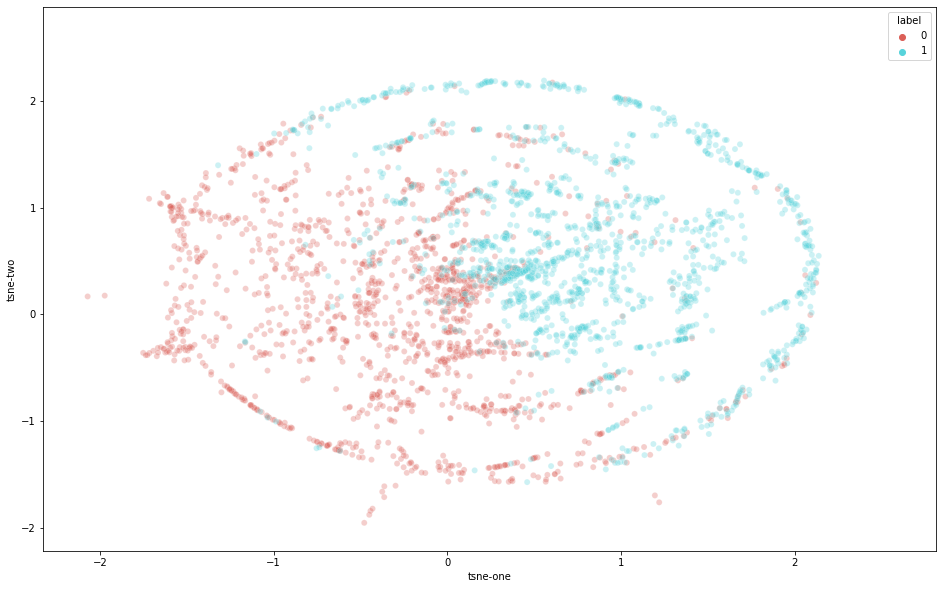

In [10]:
df_resample['tsne-one'] = tsne_results[:,0]
df_resample['tsne-two'] = tsne_results[:,1]

# Rescaling x axis
xpbot = np.percentile(df_resample['tsne-one'],1)
xptop = np.percentile(df_resample['tsne-one'],99)
xpad = 0.2*(xptop-xpbot)
xmin = xpbot - xpad
xmax = xptop + xpad

# Rescaling y axis
ypbot = np.percentile(df_resample['tsne-two'],1)
yptop = np.percentile(df_resample['tsne-two'],99)
ypad = 0.2*(yptop-ypbot)
ymin = ypbot - ypad
ymax = yptop + ypad

fig = plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="label",
    palette=sns.color_palette("hls", 2),
    data=df_resample,
    legend="full",
    alpha=0.3
)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

In [11]:
# 3D tSNE
time_start = time.time()
tsne = TSNE(n_components=3, perplexity=100, n_iter=1000, learning_rate='auto', init='random')
tsne_results = tsne.fit_transform(x_scaled)
print('t-SNE done! Time elapsed: {} seconds'.format(round(time.time()-time_start,2)))

t-SNE done! Time elapsed: 49.73 seconds


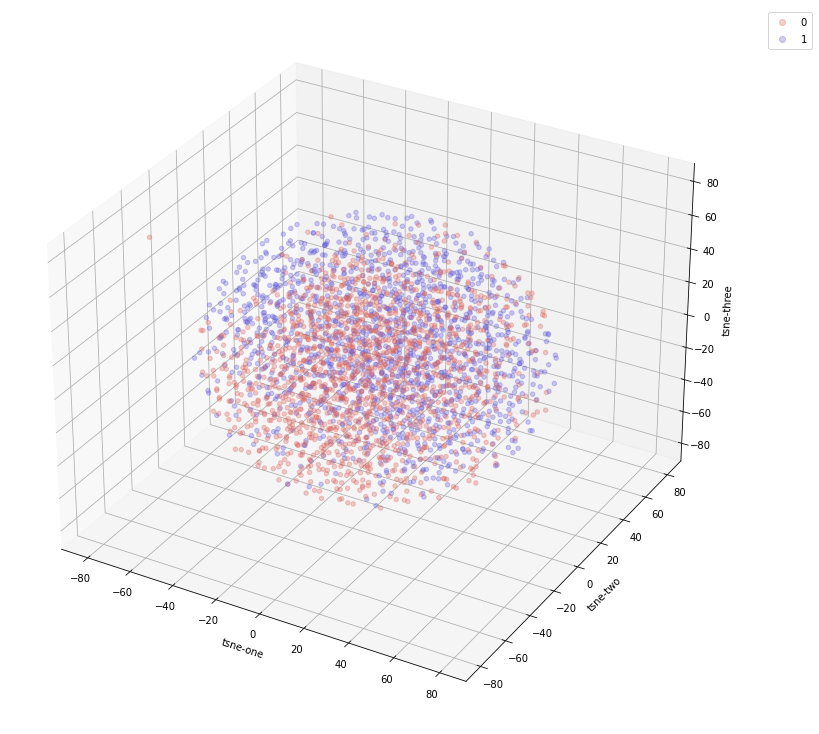

In [12]:
df_resample['tsne-one'] = tsne_results[:,0]
df_resample['tsne-two'] = tsne_results[:,1]
df_resample['tsne-three'] = tsne_results[:,2]

# Rescaling x axis
xpbot = np.percentile(df_resample['tsne-one'],1)
xptop = np.percentile(df_resample['tsne-one'],99)
xpad = 0.2*(xptop-xpbot)
xmin = xpbot - xpad
xmax = xptop + xpad

# Rescaling y axis
ypbot = np.percentile(df_resample['tsne-two'],1)
yptop = np.percentile(df_resample['tsne-two'],99)
ypad = 0.2*(yptop-ypbot)
ymin = ypbot - ypad
ymax = yptop + ypad

# Rescaling z axis
zpbot = np.percentile(df_resample['tsne-three'],1)
zptop = np.percentile(df_resample['tsne-three'],99)
zpad = 0.2*(zptop-zpbot)
zmin = zpbot - zpad
zmax = zptop + zpad

# Initializing axes
fig = plt.figure(figsize=(16,10))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# Getting colormap from seaborn
cmap = ListedColormap(sns.color_palette("hls", 3).as_hex())

# Plotting scatterplot
sc = ax.scatter(df_resample['tsne-one'],
                df_resample['tsne-two'],
                df_resample['tsne-three'],
                c=df_resample['label'], cmap=cmap, alpha=0.3)
ax.set_xlabel('tsne-one')
ax.set_ylabel('tsne-two')
ax.set_zlabel('tsne-three')
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_zlim([zmin, zmax])
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show()